# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.  

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)

In [845]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [714]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 12,6
plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [583]:
# define paths to each raw file
d_ts = {}
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [584]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [585]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-03-20 22:08:04.486837
metric: deaths at 2020-03-20 22:08:06.037674
metric: recovered at 2020-03-20 22:08:07.537006


In [834]:
# TEMP FIX - There are data issues on 2020-03-18; these are corrections that will hopefully be fixed
state_fixes_20200318 = {'New York': 3083, 
                        'Washington': 1187, 
                        'California': 870, 
                        'Florida': 330, 
                        'New Jersey': 427, 
                        'Louisiana': 280}
for state, val in state_fixes_20200318.items():
    dfp.loc[(dfp.country == 'US') & 
            (dfp['date'] == datetime.datetime(2020,3,18)) & 
            (dfp.state == state), 'confirmed'] = val

In [588]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   'recovered': np.sum,
               }))
dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [589]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='active', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-20,Italy,47021,5986,4032,627,42581,0.085749
1,2020-03-20,Germany,19848,4528,67,23,19668,0.003376
2,2020-03-20,US,19100,5423,244,44,19100,0.012775
3,2020-03-20,Spain,20410,2447,1043,213,18822,0.051102
4,2020-03-20,Iran,19644,1237,1433,149,12899,0.072948
5,2020-03-20,France,12726,1779,450,207,12714,0.035361
6,2020-03-20,China,81250,94,3253,4,9984,0.040037
7,2020-03-20,"Korea, South",8652,87,94,3,7112,0.010865
8,2020-03-20,Switzerland,5294,1219,54,13,5279,0.010200
9,2020-03-20,United Kingdom,4014,1298,178,40,3947,0.044345


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [590]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-20,Italy,47021,5986,4032,627,42581,0.085749
2,2020-03-20,US,19100,5423,244,44,19100,0.012775
1,2020-03-20,Germany,19848,4528,67,23,19668,0.003376
3,2020-03-20,Spain,20410,2447,1043,213,18822,0.051102
5,2020-03-20,France,12726,1779,450,207,12714,0.035361
9,2020-03-20,United Kingdom,4014,1298,178,40,3947,0.044345
4,2020-03-20,Iran,19644,1237,1433,149,12899,0.072948
8,2020-03-20,Switzerland,5294,1219,54,13,5279,0.010200
10,2020-03-20,Netherlands,3003,536,107,30,3001,0.035631
12,2020-03-20,Belgium,2257,462,37,16,2256,0.016393


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

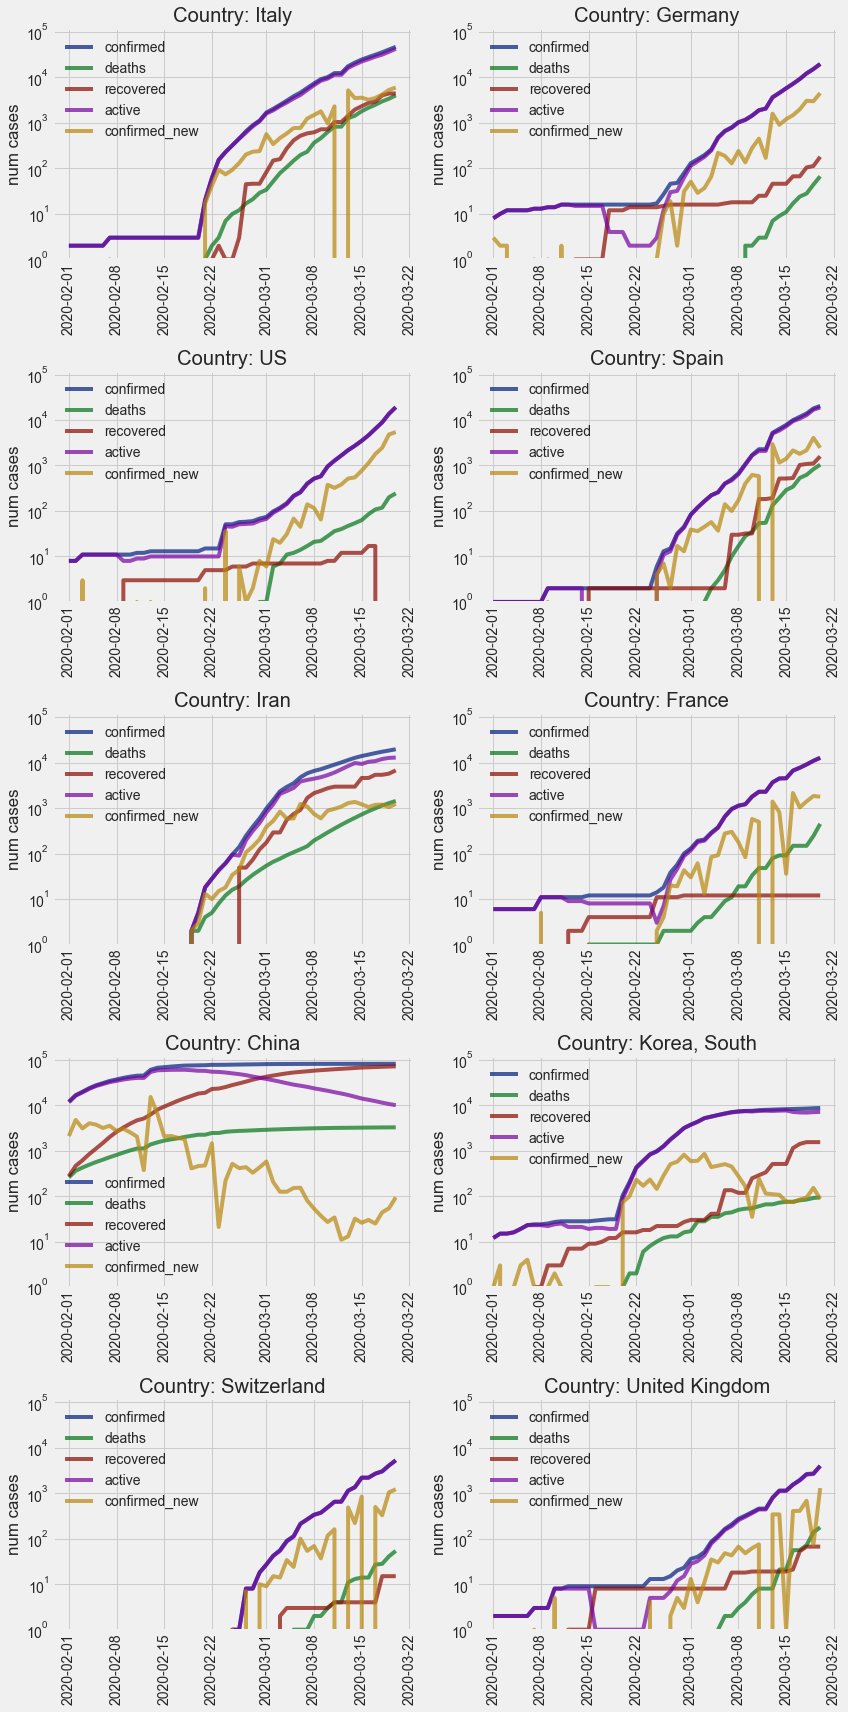

In [591]:
# plot the top countries
i = 1
n_countries = 10
n_columns = 2
n_rows = int(np.ceil(n_countries / n_columns))
plt.figure(figsize=(12,24))
y_max = dfp_top_countries['confirmed'].max() * 1.5
date_min = datetime.datetime(2020, 2, 1)

for country in dfp_top_countries.iloc[:n_countries]['country']:
    dfp_plot = dfp_country[(dfp_country['country'] == country) &
                           (dfp_country['date'] >= date_min)
                          ]
    plt.subplot(n_rows, n_columns, i)
    for key in list(d_data.keys()) + ['active', 'confirmed_new']:
        plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.7, label=key)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.ylim([1, y_max])
    plt.xticks(rotation=90)
    
    i += 1
plt.tight_layout()
plt.show()

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

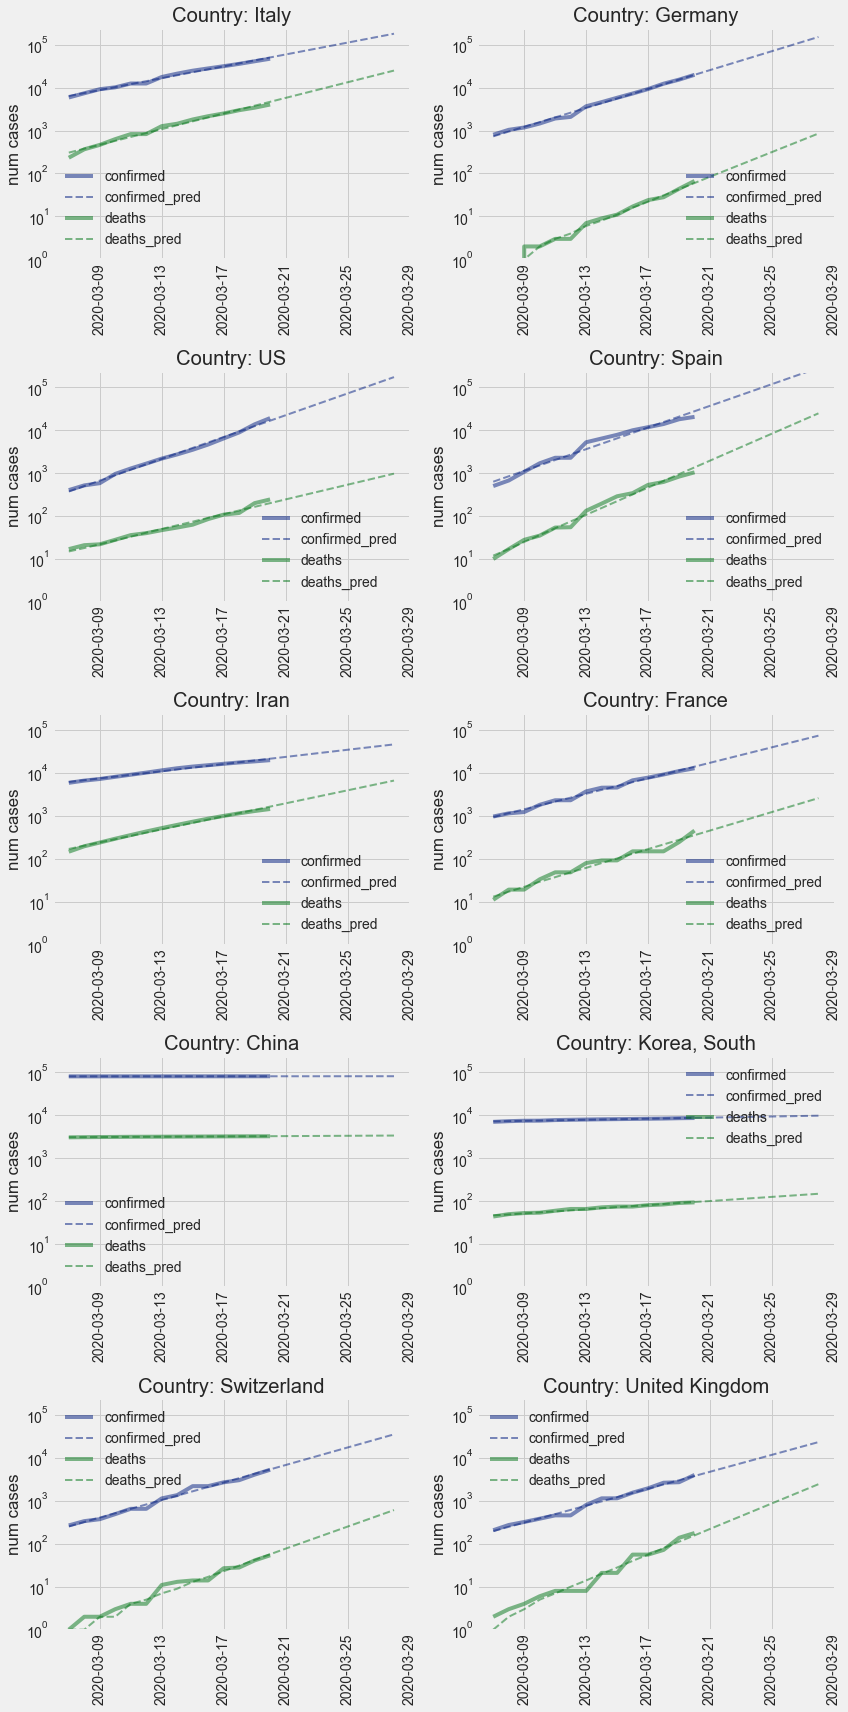

,date,country,confirmed_pred,deaths_pred
0,2020-03-21,China,81212,3282
1,2020-03-28,China,81429,3380
2,2020-03-21,France,17064,451
3,2020-03-28,France,73007,2566
4,2020-03-21,Germany,25585,84
5,2020-03-28,Germany,151087,853
6,2020-03-21,Iran,23369,1938
7,2020-03-28,Iran,45736,6573
8,2020-03-21,Italy,59055,5756
9,2020-03-28,Italy,179740,24926


In [837]:
# make predictions based on the last 2 weeks of data
date_2_weeks_ago = (dfp_country['date'].max() - datetime.timedelta(days=13))
dfp_country_recent = (dfp_country[dfp_country['date'] >= date_2_weeks_ago].
                      sort_values(by=['country', 'date'])
                     ).copy()

# clean data for fit (convert to log)
REGULARIZATION = 9E-1
dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
date_most_recent = dfp_country_recent['date'].max()

# perform fit
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp_most_recent, days=1):
    dfp_most_recent['date'] = dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent.copy()

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=date_most_recent
             ):
    dfp_country_recent = dfp_country_recent.set_index('country')
    
    # fit
    dfp_country_confirmed_fit = dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].groupby(['country']).apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
    dfp_country_recent['fits'] = dfp_country_confirmed_fit  #dfp_country_recent.groupby(['country']).apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1)) #dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'slope', 'intercept']).reset_index()
    return dfp_country_recent, dfp_country_confirmed_fit

# make predictions to past, then future
# add in future points
dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
dfp_most_recent_1 = shift_future(dfp_most_recent, 1)
dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0)
dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, col_fit='deaths_log', col_pred='deaths_pred')
dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, col_fit='confirmed_log', col_pred='confirmed_pred')

# plot the top countries
i = 1
n_countries = 10
n_columns = 2
n_rows = int(np.ceil(n_countries / n_columns))
plt.figure(figsize=(12,24))
y_max = dfp_top_countries['confirmed'].max() * 3
date_min = datetime.datetime(2020, 2, 1)
top_countries = dfp_top_countries.iloc[:n_countries]['country']

for country in top_countries:
    dfp_plot = dfp_country_recent[(dfp_country_recent['country'] == country) &
                           (dfp_country_recent['date'] >= date_min)
                          ].sort_values(by='date')
    plt.subplot(n_rows, n_columns, i)
    for key in ['confirmed', 'deaths']:
        p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, label=key)
        pred_col = f'{key}_pred'
        plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.ylim([1, y_max])
    plt.xticks(rotation=90)
    
    i += 1
plt.tight_layout()
plt.show()

dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent) &
                                   (dfp_country_recent['country'].isin(top_countries))
                                  ].sort_values(by=['country', 'date']).reset_index(drop=True)
dfp_forecasts_out = dfp_forecasts[['date', 'country', 'confirmed_pred', 'deaths_pred']].copy()
display(dfp_forecasts_out)

In [843]:
dfp_forecasts_out['date_of_forecast'] = date_most_recent
dfp_forecasts_out.head()
save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}.csv"
save_path = os.path.join('predictions', save_name)
dfp_forecasts_out.to_csv(save_path, index=False)
print(f'saved forecast to {save_path}')

saved forecast to predictions/covid-19_country_forecast_from_2020-03-20.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [695]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.3f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

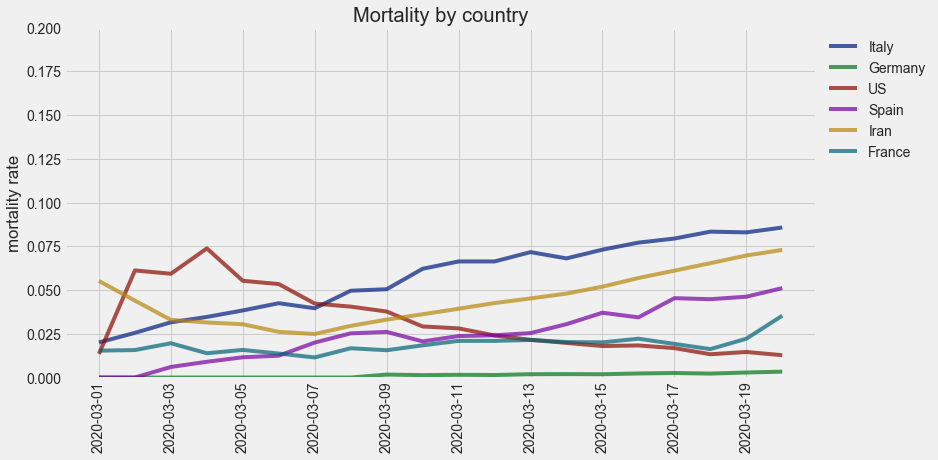

In [696]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [594]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20)
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot['confirmed'], dfp_plot['mortality_rate'], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('# confirmed cases')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality vs confirmed cases by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

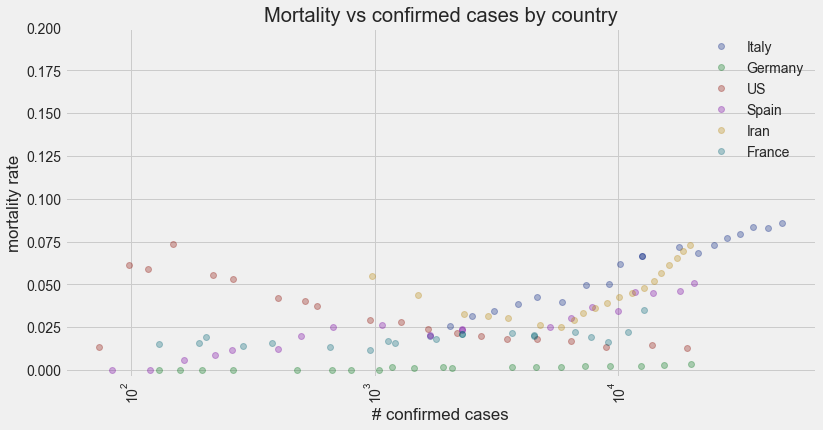

In [595]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [709]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

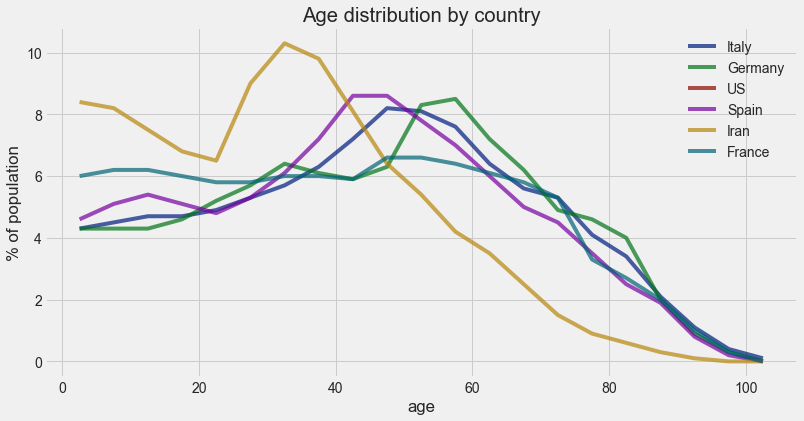

In [710]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

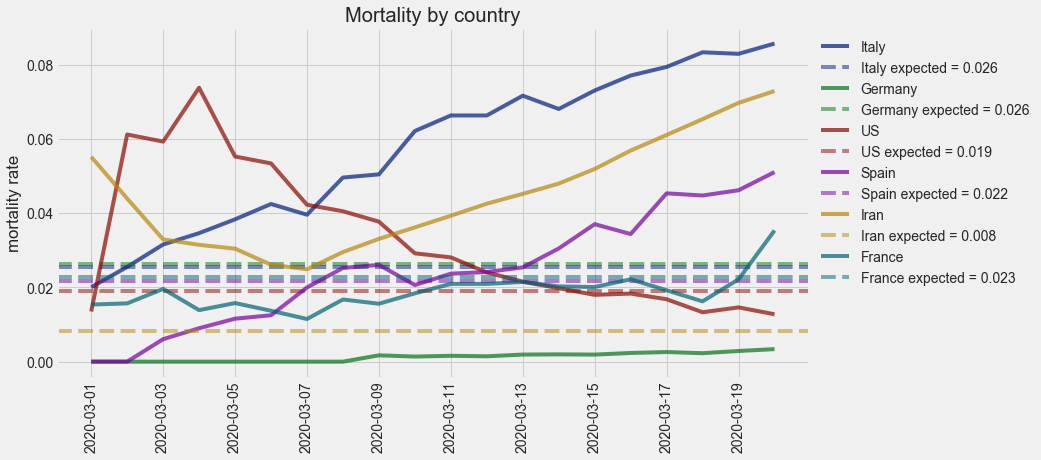

In [699]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)

### Distribution of expected mortality fractions

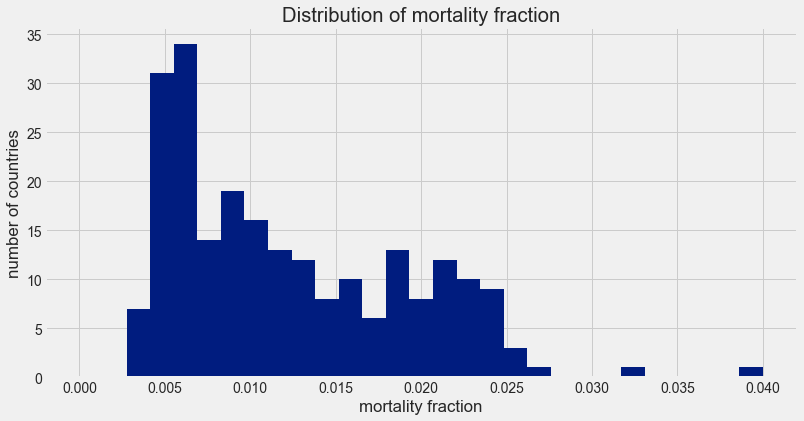

In [701]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [707]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


# Normalize infections by population

Population data taken from https://www.worldometers.info/world-population/population-by-country/ on 2020-03-16

In [596]:
dfp_world_pop = pd.read_csv('supporting_data/country_population_data.csv')

In [597]:
# clean population data
dfp_world_pop = dfp_world_pop.rename(columns={
    'Country (or dependency)': 'country', 
    'Population\n (2020)': 'population'
})
dfp_world_pop['population'] = dfp_world_pop['population'].apply(lambda x: float(x.replace(',', '')))

In [598]:
translations = {'South Korea': 'Korea, South',
                'United States': 'US',
               }
for old, new in translations.items():
    try:
        dfp_world_pop['country'][np.where(dfp_world_pop['country'] == old)[0][0]] = new
    except Exception as e:
        pass  #print(e)

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [599]:
# filter in only the top countries
top_n = 10
pop_cols = ['country', 'population']
dfp_country_top = dfp_country.merge(dfp_top_countries.iloc[:top_n]['country'], on='country', how='inner')
dfp_country_top_dec = dfp_country_top.merge(dfp_world_pop[pop_cols], on='country', how='left')
dfp_country_top_dec['confirmed_frac'] = dfp_country_top_dec['confirmed'] / dfp_country_top_dec['population']
dfp_country_top_dec['deaths_frac'] = dfp_country_top_dec['deaths'] / dfp_country_top_dec['population']

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [600]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_top_dec, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

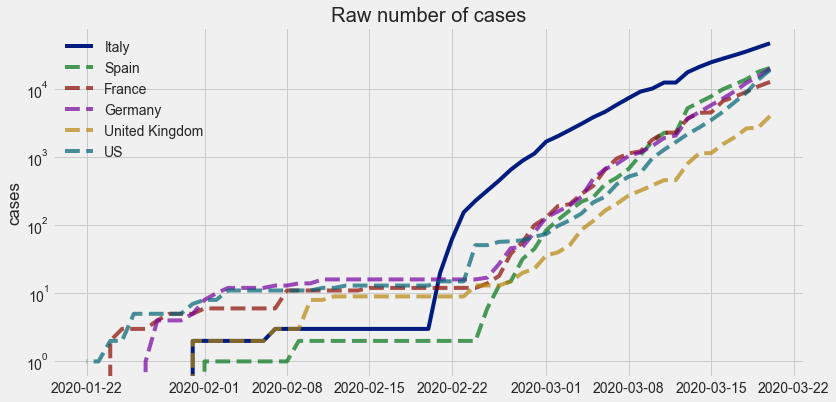

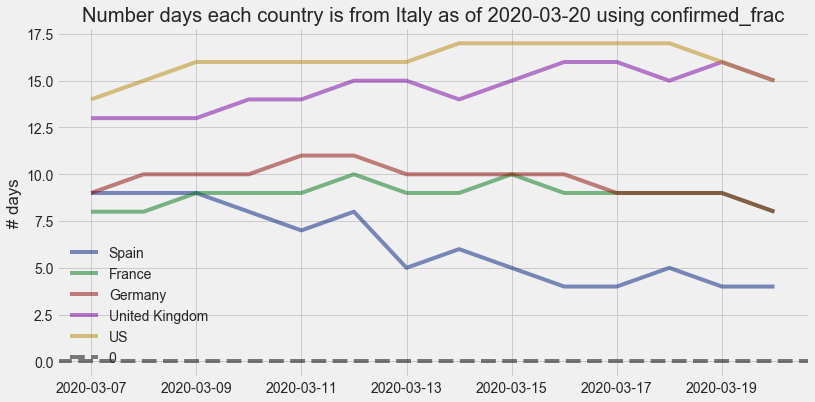

In [601]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed_frac')

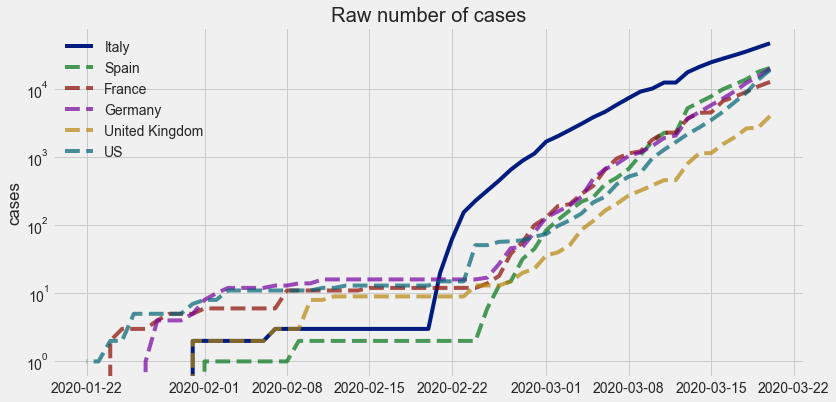

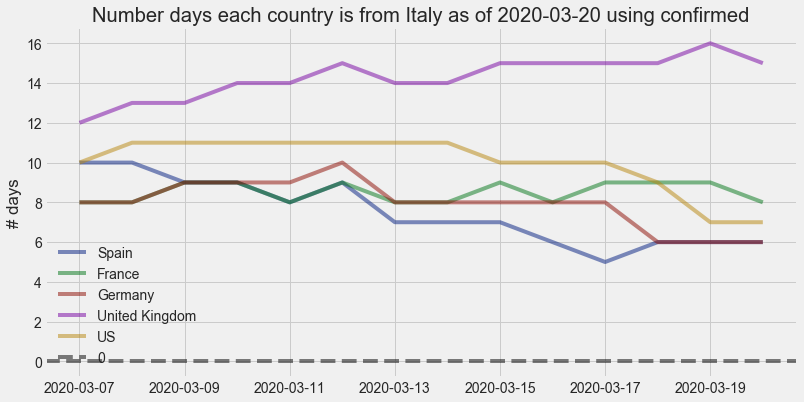

In [602]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed')

# US state breakdown

In [603]:
# look only at the US
dfp_us_raw = dfp[dfp['country'] == 'US']
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [604]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [605]:
id_cols_state = ['date', 'state']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols]
dfp_us_top_states = dfp_us_top_states.sort_values(by='active', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(10)

,date,state,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-20,New York,8310,2945,42,8,8310,0.005054
1,2020-03-20,Washington,1524,148,83,9,1524,0.054462
2,2020-03-20,California,1177,225,23,5,1177,0.019541
3,2020-03-20,New Jersey,890,148,11,2,890,0.012360
4,2020-03-20,Illinois,585,163,5,1,585,0.008547
5,2020-03-20,Florida,563,146,10,1,563,0.017762
6,2020-03-20,Michigan,552,218,3,0,552,0.005435
7,2020-03-20,Louisiana,538,146,14,4,538,0.026022
8,2020-03-20,Georgia,420,133,13,3,420,0.030952
9,2020-03-20,Massachusetts,413,85,1,1,413,0.002421


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [606]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

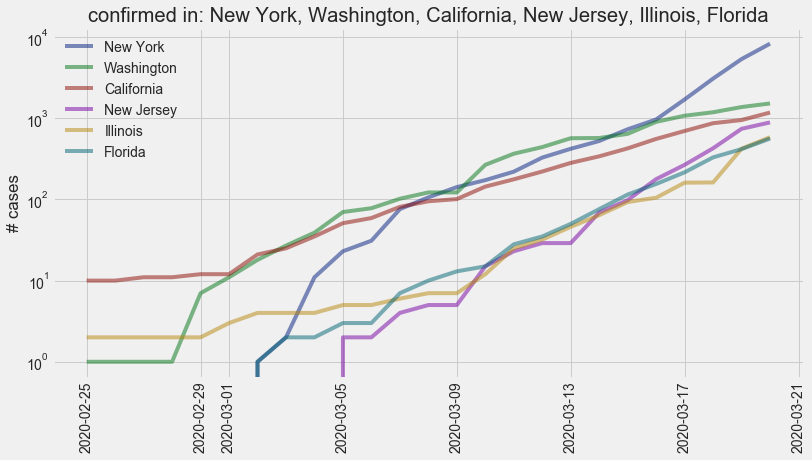

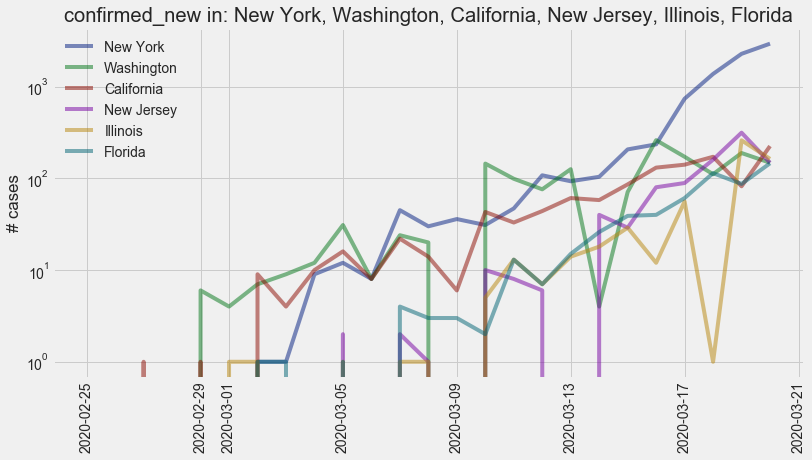

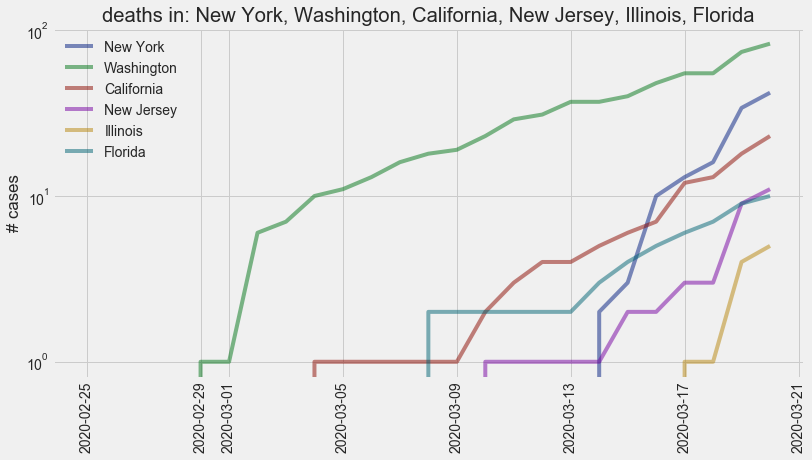

In [614]:
states_oi = dfp_us_top_states.iloc[:6]['state'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

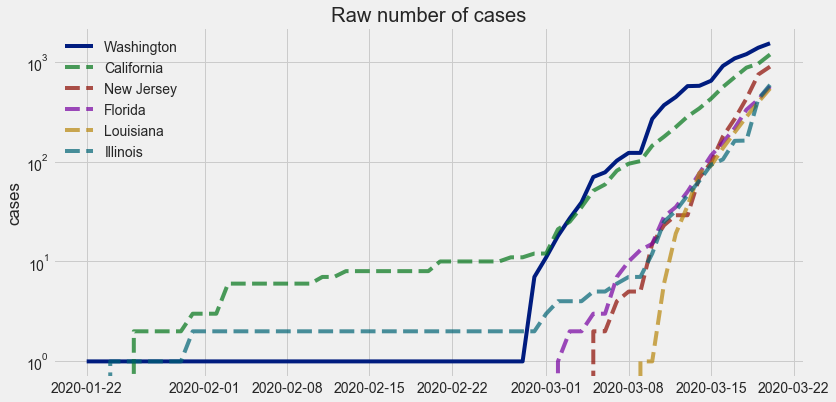

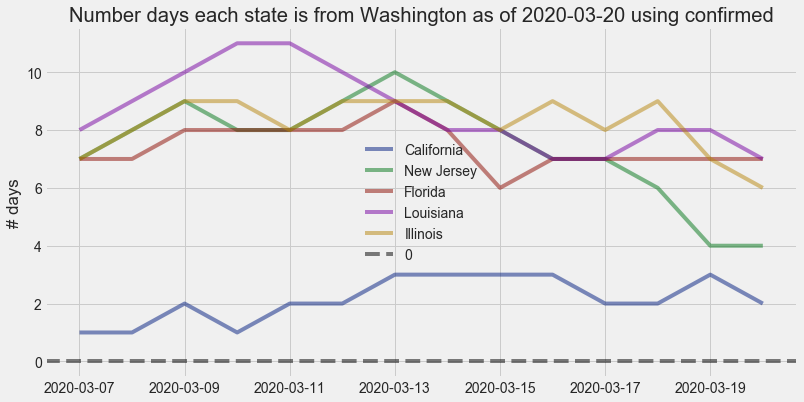

In [608]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

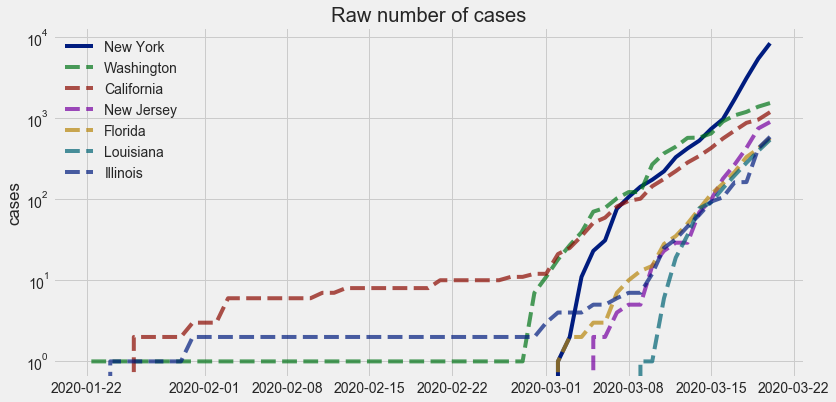

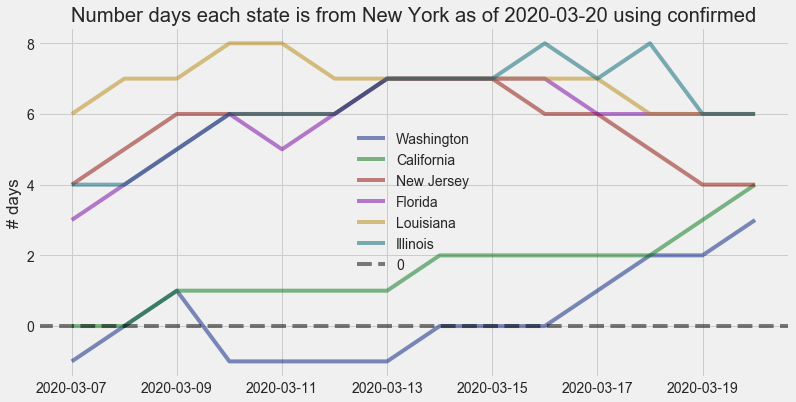

In [609]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

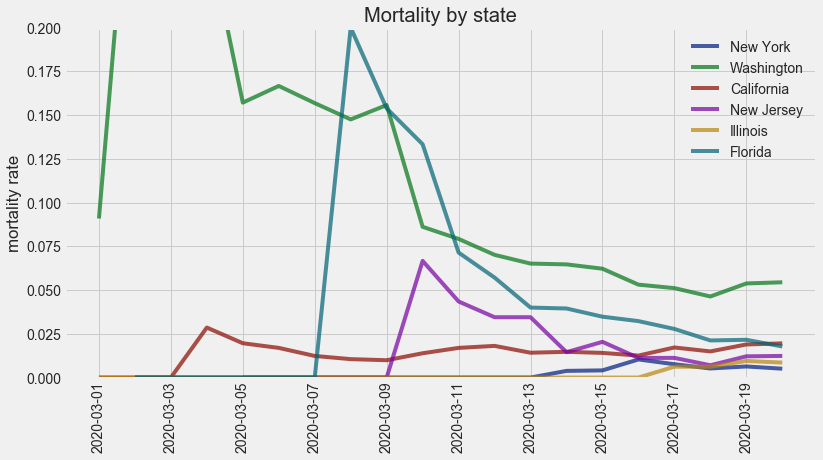

In [610]:
n_states = 6
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

##### Relationship between mortality rate and number of cases

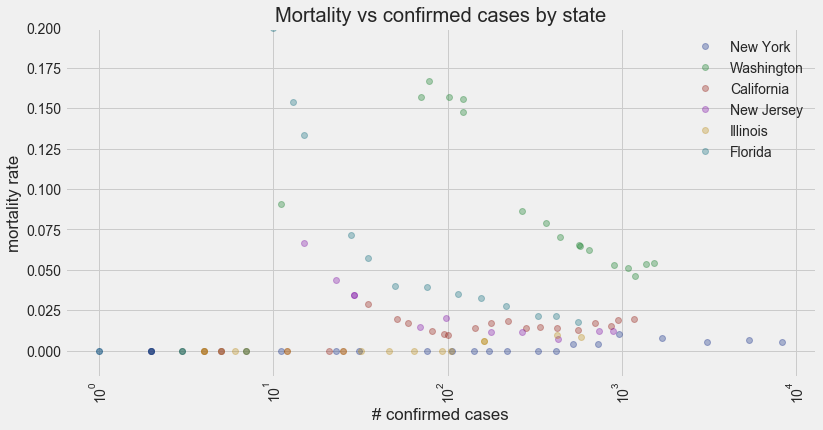

In [611]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))